In [1]:
import torch
from tqdm import tqdm
from BertForRescoring.RescoreBert import RescoreBert
from transformers import BertTokenizer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json

/mnt/nas3/Alfred/espnet/tools/anaconda/envs/espnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loss = torch.load('./log/RescoreBert/nBestTransformer/loss.pt')
loss

{'training_loss': [tensor(4.4956),
  tensor(3.7014),
  tensor(3.6249),
  tensor(3.5536),
  tensor(2.4602),
  tensor(3.4678),
  tensor(3.3562),
  tensor(3.3606),
  tensor(3.2947),
  tensor(2.2840),
  tensor(3.2150),
  tensor(3.0658),
  tensor(3.0656),
  tensor(2.9702),
  tensor(2.0427),
  tensor(2.8560),
  tensor(2.6868),
  tensor(2.6781),
  tensor(2.5908),
  tensor(1.7843),
  tensor(2.4996),
  tensor(2.3448),
  tensor(2.3421),
  tensor(2.2558),
  tensor(1.5458),
  tensor(2.1439),
  tensor(1.9645),
  tensor(1.9274),
  tensor(1.8341),
  tensor(1.2473),
  tensor(1.7188),
  tensor(1.5598),
  tensor(1.5182),
  tensor(1.4411),
  tensor(0.9861),
  tensor(1.3549),
  tensor(1.2190),
  tensor(1.1821),
  tensor(1.1267),
  tensor(0.7742),
  tensor(1.0700),
  tensor(0.9571),
  tensor(0.9296),
  tensor(0.8930),
  tensor(0.6173),
  tensor(0.8574),
  tensor(0.7660),
  tensor(0.7402),
  tensor(0.7149),
  tensor(0.4964),
  tensor(0.6966),
  tensor(0.6203),
  tensor(0.5945),
  tensor(0.5816),
  tensor(0.

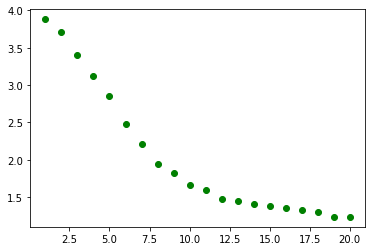

In [6]:
dev_loss = [l.item() for l in loss["dev_loss"]]
dev_loss

plt.plot(range(1,21), dev_loss, 'go')

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [3]:
device = 'cuda:0'if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [4]:
model = RescoreBert(
    train_batch=1,
    test_batch=1,
    nBest=10,
    use_MWER=True,
    use_MWED=False,
    device=device,
    lr=1e-4,
    weight=0.59
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
state_dict = torch.load('./checkpoint/MWER/checkpoint_train_4.pt')
model.model.load_state_dict(state_dict["state_dict"])

<All keys matched successfully>

In [ ]:
# token = '甚 至 出 现 交 易 几 乎 停 止 的 情 况'.split()
# token = '甚 至 出 现 交 易 几 乎 停 滞 的 情 况'.split()
token_ref = '楼 市 调 控 的 行 政 手 段 宜 减 不 宜 加'.split()
token_hyp = '楼 市 调 控 的 行 政 手 段 意 见 不 一 一'.split()
token_hyp_2 = '楼 市 调 控 的 行 政 手 段 意 见 不 一'.split()
token_id_ref = tokenizer.convert_tokens_to_ids(token_ref)
token_id_hyp = tokenizer.convert_tokens_to_ids(token_hyp)
token_id_hyp_2 = tokenizer.convert_tokens_to_ids(token_hyp_2)
token_id_ref = [101] + token_id_ref + [102]
token_id_hyp = [101] + token_id_hyp + [102]
token_id_hyp_2 = [101] + token_id_hyp_2 + [102]

In [8]:
cos = torch.nn.CosineSimilarity()

In [9]:
input_id_ref = torch.tensor(token_id_ref).unsqueeze(0).to(device)
input_id_hyp = torch.tensor(token_id_hyp).unsqueeze(0).to(device)
input_id_hyp_2 = torch.tensor(token_id_hyp_2).unsqueeze(0).to(device)

print(input_id_hyp)
print(input_id_hyp_2)
with torch.no_grad():
    output_ref = model.model(
        input_ids = input_id_ref,
    )[0]
    output_hyp = model.model(
        input_ids = input_id_hyp,
    )[0]

    output_hyp_2 = model.model(
        input_ids = input_id_hyp_2,
    )[0]

    sim = cos(output_ref.squeeze(0)[0], output_hyp_2.squeeze(0)[0])
    print(sim)

NameError: name 'token_id_ref' is not defined

In [110]:
distribution_dict = dict()
recog_set = ['dev', 'test']
for task in recog_set:
    distribution_dict[task] = {
        1:0,
        0.95:0,
        0.75:0,
        0.5:0,
        0.25:0,
        0:0,
        'same':0
    }

In [111]:
cos = torch.nn.CosineSimilarity(0)
for task in recog_set:
    print(task)
    data = None
    with open(f'./data/aishell_{task}/rescore/MD_rescore_data.json') as f:
        data = json.load(f)
    
    for k in data['utts'].keys():
        
        token_ref = data['utts'][k]['output']['text_token'].split()
        token_hyp = data['utts'][k]['output']['rec_token'].split()  

        if (token_ref == token_hyp):
            distribution_dict[task]['same'] += 1
            continue

        token_id_ref = tokenizer.convert_tokens_to_ids(token_ref)
        token_id_hyp = tokenizer.convert_tokens_to_ids(token_hyp)
        token_id_ref = [101] + token_id_ref + [102]
        token_id_hyp = [101] + token_id_hyp + [102]

        input_id_ref = torch.tensor(token_id_ref).unsqueeze(0).to(device)
        input_id_hyp = torch.tensor(token_id_hyp).unsqueeze(0).to(device)
        with torch.no_grad():
            output_ref = model.model(
                input_ids = input_id_ref,
            )[0]

            output_hyp = model.model(
                input_ids = input_id_hyp,
            )[0]

        output_ref = output_ref.squeeze(0)[0]
        output_hyp = output_hyp.squeeze(0)[0]

        sim = cos(output_ref, output_hyp)
        if (sim >= 1):
            distribution_dict[task][1] += 1
        elif (sim < 1 and sim >= 0.95):
            distribution_dict[task][0.95] += 1
        elif (sim < 0.95 and sim >= 0.75):
            distribution_dict[task][0.75] += 1
        elif (sim < 0.75 and sim >= 0.5):
            distribution_dict[task][0.5] += 1
        elif (sim < 0.5 and sim >= 0.25):
            distribution_dict[task][0.25] += 1
        elif (sim < 0.25):
            distribution_dict[task][0] += 1

dev
test


In [105]:
distribution_dict['dev']

{1: 0, 0.95: 2204, 0.75: 1697, 0.5: 483, 0.25: 81, 0: 12, 'same': 9849}

In [106]:
distribution_dict['test']

{1: 0, 0.95: 1037, 0.75: 966, 0.5: 342, 0.25: 37, 0: 8, 'same': 4786}

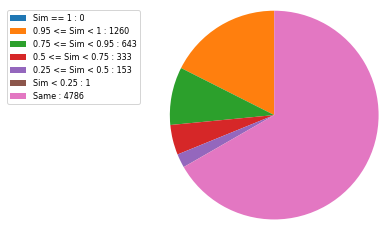

In [115]:
task = 'test'
labels = ["Sim == 1", "0.95 <= Sim < 1", "0.75 <= Sim < 0.95", "0.5 <= Sim < 0.75", "0.25 <= Sim < 0.5", "Sim < 0.25", "Same"]
value = list(distribution_dict[task].values())
fig, axe = plt.subplots()
patches, texts = plt.pie(
    value,
    startangle=90, radius=1.2 
    )

legend_labels = ['{} : {}'.format(k, v) for k, v in zip(labels, value)]

# sort_legend = True
# if sort_legend:
#     patches, labels, dummy =  zip(*sorted(zip(patches, labels, list(distribution_dict['test'].values())),
#                                           key=lambda x: x[2],
#                                           reverse=True))

plt.legend(patches, legend_labels, loc = 'best', bbox_to_anchor=(-0.1, 1), fontsize=8)

plt.show()

In [ ]:
model.eval()
input_id = torch.tensor(token_id_hyp).unsqueeze(0)
with torch.no_grad():
    attention_map = model.model(
        input_ids = input_id,
        output_attentions = True
    ).attentions


In [ ]:
input_id_ref = torch.tensor(token_id_ref).unsqueeze(0)
input_id_hyp = torch.tensor(token_id_hyp).unsqueeze(0)
with torch.no_grad():
    output_ref = model.model(
        input_ids = input_id_ref,
    )[0]

    output_hyp = model.model(
        input_ids = input_id_hyp,
    )[0]

output_ref = output_ref.squeeze(0)[0]
output_hyp = output_hyp.squeeze(0)[0]

In [ ]:

print(cos(output_ref.squeeze(0)[0], output_hyp.squeeze(0)[0]))

In [ ]:
fig, axe = plt.subplots(figsize = (10,10))
total_map = np.zeros(attention_map[0][0][0].shape)
for i in range(len(attention_map)):
    np_map = attention_map[i].numpy().squeeze(0)
    np_map = np_map[-1]
    np_map = np_map * 1e8
    np_map = np_map.astype(int)
    np_map = np_map / np.linalg.norm(np_map)
    total_map += np_map
# total_map = np.insert(total_map, 10, 0, axis = 1)
# total_map = np.insert(total_map, 10, 0, axis = 0)
c = axe.pcolor(total_map, vmin = 0, vmax = 1)
fig.colorbar(c, ax = axe)
plt.show()